In [15]:
import pandas as pd

path = "youtube_comments_climate_change/cleaned_data.csv"
data = pd.read_csv(path, sep=",", encoding='utf-8', index_col=[0])

list(data.columns)

['publishedAt', 'authorName', 'text', 'isReply', 'cleaned']

In [16]:
import numpy as np

embeddings = np.load('embeddings.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

In [17]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

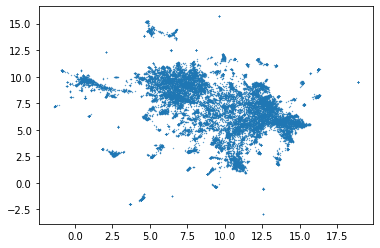

In [18]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(embeddings)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], s=0.1, cmap='Spectral');

In [21]:
kmeans_labels = cluster.KMeans(n_clusters=10).fit_predict(standard_embedding)

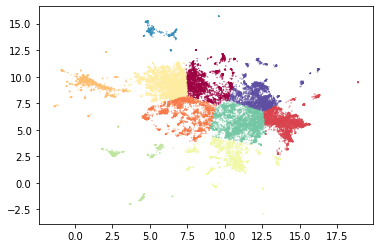

In [22]:
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans_labels, s=0.1, cmap='Spectral');

In [23]:
lowd_data = PCA(n_components=50).fit_transform(embeddings)
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(lowd_data)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


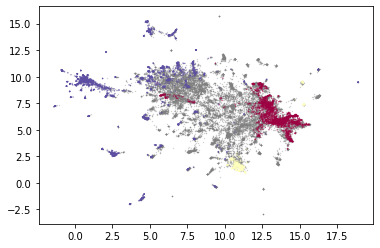

In [24]:
clustered = (hdbscan_labels >= 0)
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=hdbscan_labels[clustered],
            s=0.1,
            cmap='Spectral');